# Chapter 2: Single cell simulation with external feedfoward input (with BioNet)

In the previous tutorial we built a single cell and stimulated it with a current injection. In this example we will keep our single-cell network, but instead of stimulation by a step current, we'll set-up an external network that synapses onto our cell.

**Note** - scripts and files for running this tutorial can be found in the directory [sources/chapter02/](sources/chapter02)

Requirements:
* bmtk
* NEURON 7.4+

## Step 1: Building the network.

Similar to the previous tutorial, we want to build and save a network consisting of a single biophysically detailed cell. TODO: Add link with explaination.

In [ ]:
from bmtk.builder.networks import NetworkBuilder


cortex = NetworkBuilder('mcortex')
cortex.add_nodes(cell_name='Scnn1a',
                 potental='exc',
                 level_of_detail='biophysical',
                 params_file='472363762_fit.json',
                 morphology_file='Scnn1a.swc',
                 set_params_function='Biophys1')

cortex.build()
cortex.save_nodes(output_dir='network')


But we will also want a collection of external spike-generating cells that will synapse onto our cell. To do this we create a second network which can represent thalamic input. We will call our network "mthalamus", and it will consist of 10 cells. These cells are not biophysical but instead "filter" cells. Filter cells don't have a morphology or the normal properties of a neuron. Rather filter cells (also called virtual cells) are just spike generators.

In [ ]:
thalamus = NetworkBuilder('mthalamus')
thalamus.add_nodes(N=10,
                   pop_name='tON',
                   potential='exc',
                   level_of_detail='filter')

Now that we built our nodes, we want to create a connection between our 10 thalamic cells onto our cortex cell. To do so we use the add_edges function like so:

In [ ]:
thalamus.add_edges(source={'pop_name': 'tON'}, target=cortex.nodes(),
                   connection_rule=5,
                   weight_max=5e-05,
                   delay=2.0,
                   weight_function='wmax',
                   target_sections=['basal', 'apical'],
                   distance_range=[0.0, 150.0],
                   params_file='AMPA_ExcToExc.json',
                   set_params_function='exp2syn')

Let us break down how this method call works:
```python
thalamus.add_edges(source={'pop_name': 'tON'}, target=cortex.nodes(),
```
* Here we specify which set of nodes to use as sources and targets. Our source/pre-synaptic cells are all thamalus cells with the property "pop_name=tON", which in this case is every thalmus cell (We could also use source=thalamus.nodes(), or source={'level_of_detail': 'filter'}). The target/post-synaptic is all cell(s) of the "cortex" network.

```python
   connection_rule=5,
```
* The connection_rule parameter determines how many synapses exists between every source/target pair. In this very trivial case we are indicating that between every thamalic --> cortical cell connection, there are 5 synapatic connections. In future tutorials we will show how we can create more complex customized rules.

```python
   weight_max=5e-05,
   delay=2.0,
   weight_function='wmax',
```
* Here we are specifying the connection weight. For every connection in this edge-type, there is a connection strenght of 5e-05 (units) and a connection dealy of 2 ms. The weight function is used to adjusted the weights before runtime. Later we will show how to create customized weight functions.

```python
   target_sections=['basal', 'apical'],
   distance_range=[0.0, 150.0],
```
* This is used by BioNet to determine where on the post-synaptic cell to place the synapse. By default placement is random within the given section and range.
```python
params_file='AMPA_ExcToExc.json',  
set_params_function='exp2syn')
```
* The params_file give the parameters of the synpase, including the time constant and potential. Here we are using an AMPA type synaptic model with an Excitatory connection. The set_params_function is used by BioNet to convert the model into a valid NEURON synaptic object.

Finally we are ready to build the model and save the thalamic nodes and edges.

In [ ]:
thalamus.build()
thalamus.save_nodes(output_dir='network')
thalamus.save_edges(output_dir='network')

The network/ directory will contain multiple nodes and edges files. It should have nodes (and node-types) files for both the thalamus and cortex network. And edges (and edge-types) files for the thalamus --> cortex connections. Nodes and edges for different networks and their connections are spread out across different files which allows us in the future to rebuild, edit or replace part of setup in a piecemeal and efficent manner.

## Step 2: Setting up BioNet environment.
#### file structure.

Before running a simulation, we will need to create the runtime environment, including parameter files, run-script and configuration files. If using the tutorial these files will already be in place. Otherwise we can use a command-line:
```bash
 $ python -m bmtk.utils.sim_setup -n network --cell-vars cai,v --cell-vars-nodes 0 --run-time 2000.0 bionet
```

Also our cortex cell uses a Scnn1a model we can download from the Allen Cell-Types Database
```bash
 $ wget http://celltypes.brain-map.org/neuronal_model/download/482934212
 $ unzip 482934212
 $ cp fit_parameters.json components/biophysical/electrophysiology/472363762_fit.json
 $ cp reconstruction.swc components/biophysical/morphology/Scnn1a_473845048_m.swc
```

#### Spike Trains

We need to give our 10 thalamic cells spike trains. There are multiple ways to do this, but an easy way to use a csv file. The following function will create a file to provide the spikes for our 10 cells.


In [ ]:
from bmtk.utils.spike_trains import SpikesGenerator

sg = SpikesGenerator(nodes='network/mthalamus_nodes.h5', t_max=3.0)
sg.set_rate(10.0)
sg.save_csv('thalamus_spikes.csv', in_ms=True)

The spikes file consists of 10 rows with 2 columns; the gid and a list of spike times (in milliseconds). Thus you can create your own if you want.

In [1]:
import pandas as pd
pd.read_csv('thalamus_spikes.csv', sep=' ')

,gid,spike-times
0,0,"30.0534640706,67.0314389283,197.590419275,358...."
1,1,"90.6466072706,319.629936438,419.342193099,514...."
2,2,"3.15328111458,58.5199374771,235.790521844,456...."
3,3,"149.869383145,283.826630939,336.849458677,420...."
4,4,"146.493013499,319.75480814,341.85024366,471.47..."
5,5,"67.9104865236,208.730923277,275.855000119,443...."
6,6,"159.982235943,276.16111822,325.087195487,442.9..."
7,7,"145.278541696,192.667555437,287.147305668,464...."
8,8,"77.1294729685,199.70066867,277.334239823,341.0..."
9,9,"102.974724566,265.638824338,331.831519555,532...."


The last thing that we need to do is to update the configuration file to read "thalamus_spikes.csv". To do so we open config.json in a text editor and add the following to the **input** section.

```json
"input": [
    {
      "type": "external_spikes",
      "format": "csv",
      "file": "${BASE_DIR}/thalamus_spikes.csv",
      "source_nodes": "mthalamus",
    }
]
```

## 3. Running the simulation

Once our config file is setup we can run a simulation either through the command line:
```bash
$ python run_bionet.py config.json
```

or through the script

In [2]:
import bmtk.simulator.bionet.config as config
from bmtk.simulator.bionet import io, nrn
from bmtk.simulator.bionet.simulation import Simulation
from bmtk.simulator.bionet.biograph import BioGraph
from bmtk.simulator.bionet.bionetwork import BioNetwork
from bmtk.simulator.bionet.property_schemas import AIPropertySchema


conf = config.from_json('config.json')
io.setup_output_dir(conf)
nrn.load_neuron_modules(conf)
graph = BioGraph.from_config(conf, property_schema=AIPropertySchema)
net = BioNetwork.from_config(conf, graph)
sim = Simulation.from_config(conf, network=net)
sim.run()

Overwriting the output directory output:
Created a log file -- on 2017/12/04 at 20:28:09
Output directory: output -- t_wall: 0.861583 s
Config file: /home/kael/workspace/Allen/bmtk/docs/tutorial/notebooks/tutorial_2/config.json -- t_wall: 0.861833 s
Number of processors: 1  -- t_wall: 0.929632 s
Setting up network... -- t_wall: 0.929903 s
    Created morphologies -- t_wall: 1.015291 s
    Set segment properties -- t_wall: 1.018133 s
    Set segment coordinates -- t_wall: 1.099119 s
    Setting up external cells... -- t_wall: 1.100821 s
        mthalamus cells -- t_wall: 1.101198 s
Cells are built! -- t_wall: 1.115395 s
Initializing connections... -- t_wall: 1.115804 s
    Setting connections from mthalamus -- t_wall: 1.116139 s
    Setting connections from mcortex -- t_wall: 1.130675 s
Network is built! -- t_wall: 1.131019 s
Setting up recordings... -- t_wall: 1.131709 s
    Will save time series of the ECP! -- t_wall: 1.131999 s
    Will save time series of individual cells -- t_wall:

## 4. Analyzing the run

In [3]:
from bmtk.analyzer import spikes_table
spikes_table(config_file='config.json')

,time (ms),cell gid
0,187.0,0
1,338.5,0
2,494.5,0
3,554.0,0
4,697.2,0
5,814.3,0
6,1194.0,0
7,1441.8,0
8,1668.0,0
9,1872.6,0


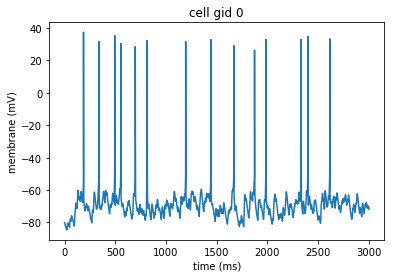

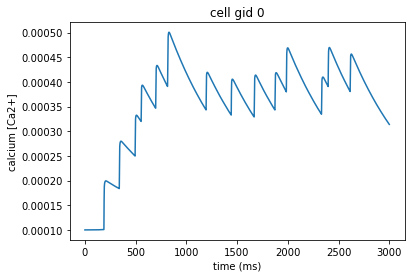

In [4]:
from bmtk.analyzer import plot_potential, plot_calcium

plot_potential(config_file='config.json')
plot_calcium(config_file='config.json')

## 5. Additional things to do:

### Changing edge properties

When using the Network Builder add_edges method, we gave all the edges the same parameter values (delay, weight, target_section, etc.). All connection created by this method call constitute an single edge-type that share the same parameters, and are specified in the mthalamic_edge_type.csv file

In [5]:
import pandas as pd
pd.read_csv('network/mthalamus_mcortex_edge_types.csv', sep=' ')

,edge_type_id,target_query,source_query,weight_max,distance_range,params_file,set_params_function,delay,target_sections,weight_function
0,100,*,pop_name=='tON',0.00005,"[0.0, 150.0]",AMPA_ExcToExc.json,exp2syn,2.0,"['basal', 'apical']",wmax


(if in the build script we called add_edges multiple times, we'd have multiple edge-types). 

Using a simple text-editor we can modify this file directly, change parameters before a simulation run without having to rebuild the entire network (although for a network this small it may not be beneficial).

#### weight_function

When BioNet builds the NEURON connected network, it uses max_weight value and wmax function to set synaptic weight. wmax is a built-in function:
```python
def wmax(target_cell, source_cell, edge_props):
    return edge_prop["weight_max"]
```

However, we have the option of providing our own custom functions to set the synaptic weight. If we call our function "adjusted_weights", then we will have to change weight_function="adjusted_weights", either in the build script or by changing edge_types.csv. Next, we must add the following code to the top of run_bionet.py (it must occur before BioNetwork.from_config() method is called).

This version of adjusted weights will randomly adjust the weight_max property.

```python
def adjusted_weights(target_cell, source_cell, edge_props):
    return random.uniform(0.5, 1.5)*edge_prop["weight_max"]

nrn.add_weight_function(adjusted_weights)
```

For more advanced functionality, we can use target_cell, source_cell, edge_props dictionary to create more complex rules:

```python
def adjusted_weights(target_cell, source_cell, edge_props):
    if target_cell['cell_name'] == 'Scnn1a':
        return edge_prop["weight_max"]*0.5
    elif target_cell['cell_name'] == 'Rorb'
        return edge_prop["weight_max"]*1.5
    else:
        ...
```

### Using NWB for spike trains

Instead of using csv files to set the spike trains of our external network, we can also use nwb files. The typical setup would look like the following in the config file:

```json
"input": [
    {
      "type": "external_spikes",
      "format": "nwb",
      "file": "$INPUT_DIR/lgn_spikes.nwb",
      "source_nodes": "LGN",
      "trial": "trial_0"
    }
]
```

Some example NWB files can be found at: LOCATION